<a href="https://colab.research.google.com/github/troncosofranco/IoT-Spark/blob/main/Prediction_Housing_w_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#House Prices Prediction with Apache Spark

### 1. About Spark
Apache Spark is an Open source analytical processing engine for large scale powerful distributed data processing and machine learning applications. Multiple frameworks can be employed:
- **Spark:** Default interface for Scala and Java
- **PySpark:** Python interface for Spark
- **SparklyR:** R interface for Spark.

### 2. Apache Spark Features
Apache Spark presents the following features:
- Distributed processing using parallelize
- Can be used with many cluster managers (Spark, Yarn, Mesos e.t.c)
- Immutable
- Lazy evaluation
- Cache & persistence
- Inbuild-optimization when using DataFrames
- ANSI SQL support

###3. Apache Spark Advantages
- Distributed processing engine.
- Applications running on Spark are 100x faster than traditional systems.
- Great benefits using Spark for data ingestion pipelines.
- Compatible with Hadoop HDFS, AWS S3, Databricks DBFS, Azure Blob Storage, and many file systems.
- Real-time data processing using *Streaming* and *Kafka*.
- Spark natively has machine learning and graph libraries.

###4. Apache Spark Architecture
Apache contains *Driver* and *Workers*. The resources are managed by Cluster Manager. Spark Driver creates a context that is an entry point to the application, and all operations (transformations and actions) are executed on worker nodes. 

###5. Cluster manager types

Spark supports the following cluster managers:
- **Standalone**: Simple cluster manager included with Spark that contributes to set up a cluster.
- **Apache Mesos:** It also runs Hadoop MapReduce and Spark applications.
- **Hadoop YARN** The resource manager in Hadoop 2. This is mostly used cluster manager.
- **Kubernetes:** Open-source system for automating deployment, scaling, and management of containerized applications.
- **Local:** It runs Spark on your computer.

#1. Import libraries

In [ ]:
#!pip install pyspark -q
import pyspark
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

Define visualization parameters

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Set random seed for notebook reproducibility


In [ ]:
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

#2. Create Spark Session

In [ ]:
spark = SparkSession.builder.master('local[2]').appName('Housing-Price-Prediction').getOrCreate()

In [ ]:
spark

Define Spark Context

In [ ]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Housing-Price-Prediction>

In [ ]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#3. Load data

Define schema: column names, column selection, and data type

In [ ]:
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

Load data from csv file

In [ ]:
df = spark.read.csv('housing_data.csv', schema=schema).cache()

Show top rows

In [ ]:
#df.take(5)
df.show()

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|   null| null|  null|    null|    null|  null|    null|  null|    null|
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
|-122.25|37.85|  52.0|   919.0|   213.0| 413.0|   193.0|4.0368|269700.0|
|-122.25|37.84|  52.0|  2535.0|   489.0|1094.0|   514.0|3.6591|299200.0|
|-122.25|37.84|  52.0|  3104.0|   687.0|1157.0|   647.0|  3.12|241400.0|
|-122.26|37.84|  42.0|  2555.0|   665.0|1206.0|   595.0|2.0804|226700.0|
|-122.25|37.84|  52.0|  3549.0|   707.0|1551.0|   7

Show dataframe columns

In [ ]:
df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

Show the Schema of the dataframe

In [ ]:
df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



#4. Data analysis

Run a column selection

In [ ]:
df.select('medinc', 'medhv').show(5)

+------+--------+
|medinc|   medhv|
+------+--------+
|  null|    null|
|8.3252|452600.0|
|8.3014|358500.0|
|7.2574|352100.0|
|5.6431|341300.0|
+------+--------+
only showing top 5 rows



4.1. How is the distribution of the median age of people living in the area?

In [ ]:
#group by medage
df_age = df.groupBy('medage').count().sort('medage', ascending = False)
df_age.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



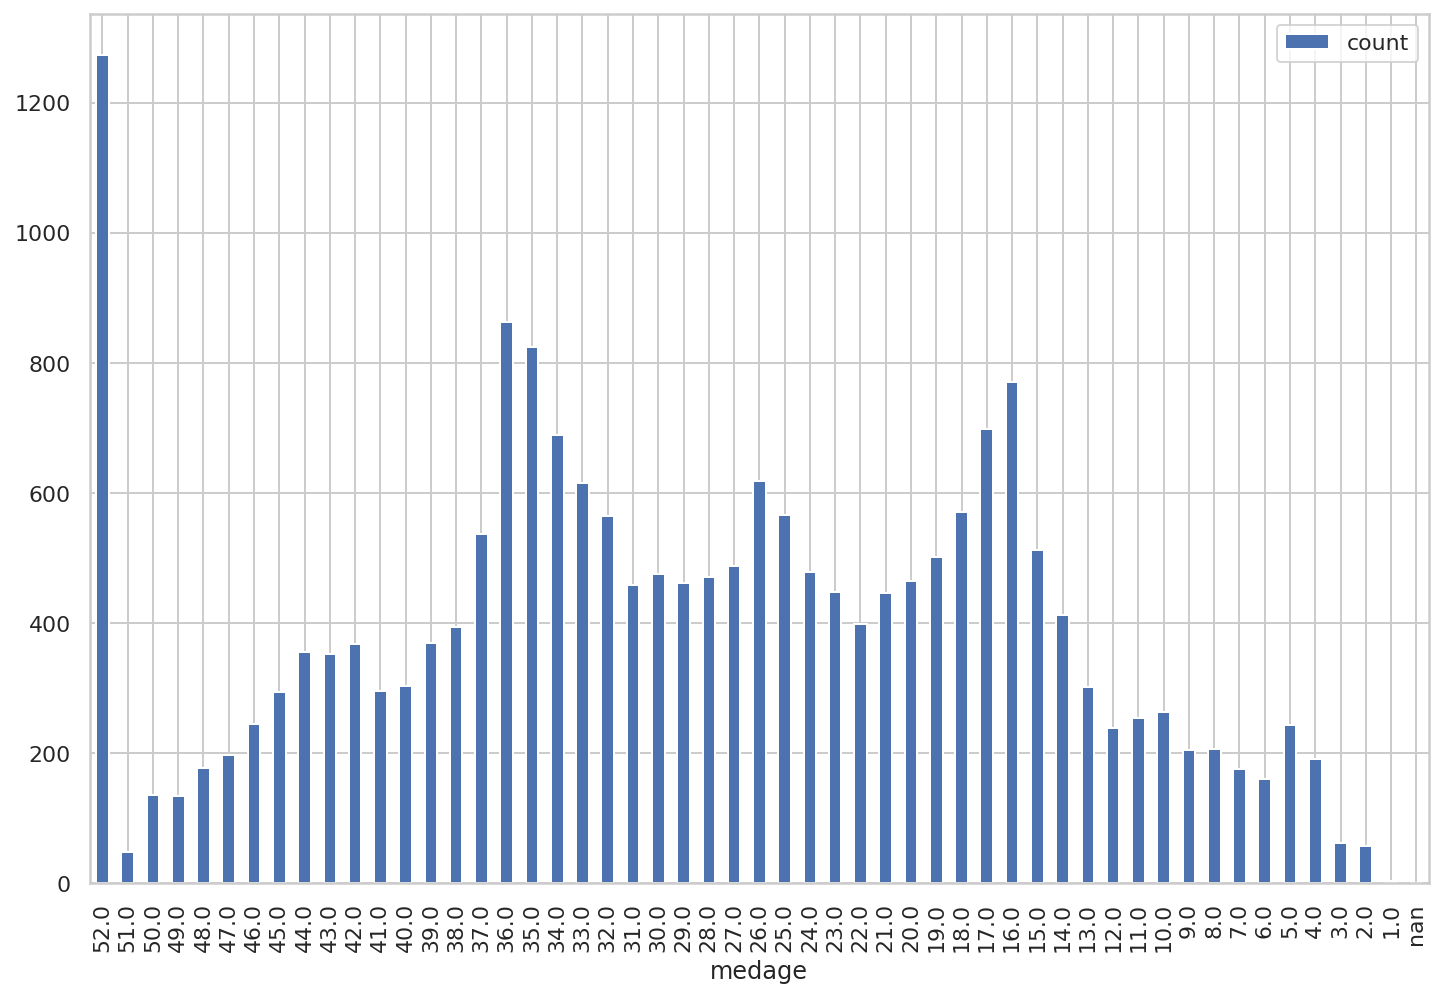

In [ ]:
#dataframe to pandas and plot
df_age.toPandas().plot.bar(x='medage', figsize=(12,8))

**Observation:** Most of residents have an average age of 52 year, followed by 33-37 and 15-20 years.

4.2. What is the statistical summary of dataframe?

In [ ]:
#pyspark.sql.functions as F
(df.describe().select(
                    "Summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|Summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20433.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631|537.8706|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.3851|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



**Observations:** The features show broad range of values. Thus, the data need to be normalized.

#5. Data Processing

Express medhv (dependent variable) in units of 100,000.

In [ ]:
df = df.withColumn('medhv', col('medhv')/100000)

Remove missing values

In [ ]:
df = df.dropna()
df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 5 rows



#6. Feature Engineering

The following columns are added to the dataframe

- Rooms per household 
- Population per household
- Bedrooms per room

Add new columns to dataframe

In [ ]:
df = (df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [ ]:
df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



**Observations:** In the first row, there are 6.98 rooms per household, the households in the block group consist of about 2.56 people and the amount of bedrooms is quite low with 0.14.

Reorder and select the columns for model building

In [ ]:
df = df.select("medhv", "totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm")

In [ ]:
df.show(5)

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|
+-----+--------+------+--------+------+--------+--------+----------+
only showing top 5 rows



## 6.1. Normalization

Normalize all features except target label

In [ ]:
feature_cols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

Use a VectorAssembler to put features into a feature vector column.

In [ ]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features") 

In [ ]:
#Create a new column with the values of the other features in a vector
assembled_df = assembler.transform(df)
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


The features have been transformed into a Dense Vector wich exception of target label.

## 6.2 Standardization

Scale the data using StandardScaler.

In [ ]:
# Initialize the standardScaler
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)


In [ ]:
scaled_df.show(10)

+-----+--------+------+--------+------+--------+--------+----------+--------------------+--------------------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|            features|     features_scaled|
+-----+--------+------+--------+------+--------+--------+----------+--------------------+--------------------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|[129.0,322.0,126....|[0.30613329508170...|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|[1106.0,2401.0,11...|[2.62467770821992...|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|[190.0,496.0,177....|[0.45089400050794...|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|[235.0,558.0,219....|[0.55768468483877...|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|[280.0,565.0,259....|[0.66447536916960...|
|2.697|   213.0| 413.0|   193.0|4.0368|    4.76|    2.14|      0.23|[213.0,413.0,193....|[0.50547590583258...|
|

#7. Model

Split the data into training and test sets using randomSplit() method.

In [ ]:
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

Create the model using Spark MLlib. ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. Elastic-net is useful when the dataset contains multiple features which are correlated with one another.

In [ ]:
#Initialize linear regression model
lr = (LinearRegression(featuresCol='features_scaled', labelCol='medhv',predictionCol='predmedhv',
                       maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [ ]:
#fit the data
linearModel = lr.fit(train_data)

#8. Model evaluation
##8.1. Model Coefficients

In [ ]:
#Model coefficients
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5321, 0.0, 0.0, 0.0])

In [ ]:
feature_cols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [ ]:
#Model Interceprt
linearModel.intercept

0.988630176977603

Display the coefficients in a dataframe

In [ ]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + feature_cols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [ ]:
coeff_df

,Feature,Co-efficients
0,Intercept,0.988630
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.532102
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


##8.2. Generate Predictions

In [ ]:
#Generate predictions
predictions = linearModel.transform(test_data)

In [ ]:
predictions.show(5)

+-------+--------+------+--------+------+--------+--------+----------+--------------------+--------------------+------------------+
|  medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|            features|     features_scaled|         predmedhv|
+-------+--------+------+--------+------+--------+--------+----------+--------------------+--------------------+------------------+
|0.14999|    28.0|  18.0|     8.0| 0.536|   12.25|    2.25|      0.29|[28.0,18.0,8.0,0....|[0.06644753691696...| 1.138795110285149|
|  0.225|   451.0|1230.0|   375.0|1.0918|    2.25|    3.28|      0.53|[451.0,1230.0,375...|[1.07027996962675...|1.2945071662747933|
|  0.225|  1743.0|6835.0|  1439.0|2.7138|    6.93|    4.75|      0.17|[1743.0,6835.0,14...|[4.13635917308076...|1.7489241674075027|
|  0.269|   543.0|1423.0|   482.0|2.1955|     5.7|    2.95|       0.2|[543.0,1423.0,482...|[1.28860759092533...|1.6037180266005446|
|  0.344|   121.0| 530.0|   115.0|2.1458|    3.08|    4.61|      0.34|[121.0

In [ ]:
# Extract the predictions and the correct labels
predAndLabels = predictions.select('medhv', 'predmedhv')
predAndLabels.show()

+-------+------------------+
|  medhv|         predmedhv|
+-------+------------------+
|0.14999| 1.138795110285149|
|  0.225|1.2945071662747933|
|  0.225|1.7489241674075027|
|  0.269|1.6037180266005446|
|  0.344|1.5897942123047901|
|  0.367|1.2824043167165895|
|  0.375| 1.864125335367453|
|  0.394|1.3609327363749195|
|  0.398|1.5239289184946858|
|  0.409|1.5653643492363898|
|  0.417|1.3171999924976807|
|  0.425|1.2198169364407725|
|  0.425|1.4770023726613912|
|   0.43|1.3423302343260983|
|  0.436|1.2521752300138236|
|   0.44|1.3261931015818265|
|   0.44|1.4761058838408705|
|  0.444|1.4259855360515208|
|  0.445|1.3606245777359096|
|  0.446|1.4679532559867374|
+-------+------------------+
only showing top 20 rows



## 8.3. Metrics

Use the LinearRegressionModel.summary attribute.

In [ ]:
# Get RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

# Get MAE
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

# Get R2
print("R2: {0}".format(linearModel.summary.r2))

RMSE: 0.8782126577044576
MAE: 0.6755195518932324
R2: 0.423891934990161


Use the RegressionEvaluator from pyspark.ml package.

In [ ]:
# Get RMSE
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predAndLabels)))

# Get MAE
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predAndLabels)))

# Get R2
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predAndLabels)))

RMSE: 0.8747210883194528
MAE: 0.6754015223732088
R2: 0.4144337498792193


In [ ]:
spark.stop()

###Credits
- [SUSHANT PATIL](https://www.kaggle.com/code/sushantpatil04/pyspark-tutorial-1-pyspark-tutorial-beginner)